## 导入所需库

In [1]:
import cal
# import imp
# imp.reload(cal)
import os,datetime,copy
from tqdm import tqdm
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 基本参数

In [2]:
# 无风险年化收益率
RF=0.015

# 融券年化利率
LR=0.08

# 交易手续费率
STOCK_FEE=0.0002

# 数据路径
PATH_STOCK_DAY="data/stock_day_data/"
PATH_BOND_DAY="data/bond_day_data/"
PATH_CON_PRICE="data/bond_convert_data/"
PATH_BASIC="data/bond_basic_info.csv"

## 读取基本信息

In [3]:
# 基本信息数据 
basic_info_data={}
stock_list=[v[0:6] for v in os.listdir(PATH_STOCK_DAY) if v[-4:]==".csv"]
bond_list=set([v[0:6] for v in os.listdir(PATH_BOND_DAY) if v[-4:]==".csv"])
bond_list=bond_list&set([v[0:6] for v in os.listdir(PATH_CON_PRICE) if v[-4:]==".csv"])
bond_list=list(bond_list)
basic_data=pd.read_csv(PATH_BASIC)
print("\neg:\n")
display(basic_data.head(3))
for i in range(len(basic_data)):
    bond_code=str(basic_data["code"][i])
    bond_name=str(basic_data["short_name"][i])
    stock_code=str(basic_data["company_code"][i])[0:6]
    start_date=basic_data["list_date"][i]
    end_date=basic_data["delist_Date"][i]
    market={"上交所":"sh","深交所主板":"sz"}[basic_data["exchange"][i]]
    if stock_code in stock_list and bond_code in bond_list:
        basic_info_data[bond_code]={"bond_code":bond_code,   # 债券代码
                                    "bond_name":bond_name,   # 债券简称
                                    "stock_code":stock_code,   # 股票代码
                                    "start_date":start_date,   # 上市日期
                                    "end_date":end_date,   # 退市日期
                                    "market":market,   # 交易市场
                                   }
print("\neg:\n")
pprint(basic_info_data[list(basic_info_data.keys())[0]])


eg:



,id,code,short_name,short_name_spelling,full_name,list_status_id,list_status,issuer,company_code,issue_start_date,...,bond_type,bond_form_id,bond_form,list_date,delist_Date,interest_begin_date,maturity_date,interest_date,last_cash_date,cash_comment
0,1,125301,丝绸转债,SCZZ,吴江丝绸股份有限公司可转换公司债券,301006,终止上市,江苏东方盛虹股份有限公司,000301.XSHE,1998-08-28,...,可转债,704001,记账式,1998-09-15,2003-08-28,1998-08-28,2003-08-28,08-28,2003-08-28,NaN
1,2,125302,茂炼转债,MLZZ,中国石化茂名炼油化工股份有限公司可转换公司债券,301006,终止上市,中国石化茂名炼油化工股份有限公司,NaN,1999-07-28,...,可转债,704001,记账式,1999-08-17,2004-07-28,1999-07-28,2004-07-28,07-28,2004-07-28,NaN
2,3,125898,鞍钢转债,agzz,鞍钢新轧钢股份有限公司可转换公司债券,301006,终止上市,鞍钢股份有限公司,000898.XSHE,2000-03-14,...,可转债,704001,记账式,2000-04-17,2005-03-14,2000-03-14,2005-03-14,存续期内每年3月14日,2005-03-14,NaN



eg:

{'bond_code': '123035',
 'bond_name': '利德转债',
 'end_date': '2025-11-14',
 'market': 'sz',
 'start_date': '2019-12-09',
 'stock_code': '300296'}


## 读取转股价格信息

In [4]:
for code in basic_info_data:
    price_data=[]
    get_data=pd.read_csv(PATH_CON_PRICE+"{}.csv".format(code))
    get_data=get_data.sort_values(by="adjust_date",axis=0,ascending=True)
    for i in range(len(get_data)):
        convert_price=get_data["new_convert_price"][i]
        start_date=max(basic_info_data[code]["start_date"],get_data["adjust_date"][i])
        if i==len(get_data)-1:
            end_date=basic_info_data[code]["end_date"]
        else:
            end_date=get_data["adjust_date"][i+1]
        price_data.append({"convert_price":convert_price,   # 转股价
                           "date":(start_date,end_date),   # 时间区间(<=,<)
                          })
        basic_info_data[code]["convert_price"]=price_data
print("\neg:\n")
display(get_data)
print("\neg:\n")
pprint(basic_info_data[list(basic_info_data.keys())[0]])


eg:



,id,code,name,pub_date,adjust_date,new_convert_price,adjust_reason
0,5115,123151,康泰医学系统(秦皇岛)股份有限公司向不特定对象发行可转换公司债券,2022-06-28,2022-06-28,28.22,初始转股价



eg:

{'bond_code': '123035',
 'bond_name': '利德转债',
 'convert_price': [{'convert_price': 7.04,
                    'date': ('2019-12-09', '2020-05-15')},
                   {'convert_price': 6.98,
                    'date': ('2020-05-15', '2021-05-24')},
                   {'convert_price': 6.96,
                    'date': ('2021-05-24', '2022-05-17')},
                   {'convert_price': 6.91,
                    'date': ('2022-05-17', '2025-11-14')}],
 'end_date': '2025-11-14',
 'market': 'sz',
 'start_date': '2019-12-09',
 'stock_code': '300296'}


## 构建交易池

In [5]:
start_date="2018-01-01"   # 回测日期 设置
end_date="2019-01-01"
def get_trade_pool(start_date=start_date,end_date=end_date):
    backtest_start_date=start_date
    backtest_end_date=end_date
    benchmark_data=pd.read_csv("data/hs300_day.csv")
    benchmark_data=benchmark_data[benchmark_data["date"]>=backtest_start_date]
    benchmark_data=benchmark_data[benchmark_data["date"]<=backtest_end_date]
    backtest_date_list=list(benchmark_data["date"])
    limit_days=int(0.9*len(backtest_date_list))
    # 交易池
    trade_pool=[]
    for code in basic_info_data:
        # 剔除在回测开始区间后上市的
        if basic_info_data[code]["start_date"]>backtest_start_date:
            continue
        # 剔除到期时间不足一年的
        end_time=cal.strToDate(basic_info_data[code]["end_date"])-cal.strToDate(backtest_end_date)
        if end_time.days<365:
            continue
        day_data=pd.read_csv(PATH_BOND_DAY+"{}.csv".format(code))
        day_data=day_data[backtest_start_date<=day_data["date"]]
        day_data=day_data[day_data["date"]<=backtest_end_date]
        # 剔除停牌时间过长的
        if len(day_data)<limit_days:
            continue
        trade_pool.append(code)
    print("\n策略池:\n")
    print(trade_pool)
    return trade_pool,backtest_date_list
trade_pool,backtest_date_list=get_trade_pool()


策略池:

['110031', '110033', '110034', '128010', '113009', '128012', '127003', '128013', '113011', '113012', '128014', '127004', '128015', '113013', '113014', '128017', '128018', '113016', '128019', '110038', '128020', '128021', '128023', '128025']


## 策略&回测

In [6]:
### 选取整年数据，以周为单位进行交易，持有1份转债的同时，做空(Price_bond/Price_stock)*Delta份对应股票
def backtest(trade_pool,backtest_start_date,backtest_end_date,backtest_date_list,daybt=0):   # daybt=1为日回测
    backtest_data={}
    for bond_code in tqdm(trade_pool):
        stock_code=basic_info_data[bond_code]["stock_code"]
        bond_all_data=pd.read_csv(PATH_BOND_DAY+"{}.csv".format(bond_code))
        stock_all_data=pd.read_csv(PATH_STOCK_DAY+"{}.csv".format(stock_code))
        bond_data=bond_all_data[bond_all_data["date"]>=backtest_start_date]
        bond_data=bond_data[bond_data["date"]<=backtest_end_date]
        stock_data=stock_all_data[stock_all_data["date"]>=backtest_start_date]
        stock_data=stock_data[stock_data["date"]<=backtest_end_date]
        # 以回测第一日为起始日，计算复权修正因子
        stock_data["factor"]=stock_data["factor"]/list(stock_data["factor"])[0]
        bond_date_list=list(set(list(bond_data["date"]))&set(list(stock_data["date"])))
        for trade_date in backtest_date_list:
            # 开始交易
            if trade_date in bond_date_list:
                # 期权有效期T
                syear=cal.strToDate(basic_info_data[bond_code]["end_date"])-cal.strToDate(trade_date)
                syear=syear.days/365
                bond_this_day_data=bond_data[bond_data["date"]==trade_date]
                stock_this_day_data=stock_data[stock_data["date"]==trade_date]
                stock_price=list(stock_this_day_data["close"])[0]
                factor_fq=list(stock_this_day_data["factor"])[0]
                stock_price_fq=stock_price*factor_fq
                bond_price=list(bond_this_day_data["close"])[0]
                # 转股价
                for cdata in basic_info_data[bond_code]["convert_price"]:
                    if cdata["date"][0]<=trade_date<cdata["date"][1]:
                        convert_price=cdata["convert_price"]
                        break
                else:
                    print(bond_code+" "+trade_date)
                    if bond_code in backtest_data:del backtest_data[bond_code]
                    break
                # 计算溢价率
                pr=bond_price*convert_price/100/stock_price-1
                date_data={"date":trade_date,
                           "bond_price":bond_price,
                           "stock_price":stock_price,
                           "convert_price":convert_price,
                           "stock_price_fq":stock_price_fq,
                           "factor_fq":factor_fq,
                           "pr":pr,
                           }

                if bond_code not in backtest_data:
                    # 买入一张可转债
                    trade_price=list(bond_this_day_data["close"])[0]
                    date_data["hold_short"]={"volume":0}
                    date_data["cash"]=0
                    backtest_data[bond_code]={"hold_bond":{"cost_price":bond_price,"volume":1},
                                              "date_data":[date_data],
                                              "trade_data":[]}
                else:
                    last_date_data=backtest_data[bond_code]["date_data"][-1]
                    last_date=bond_date_list[bond_date_list.index(trade_date)-1]
                    last_convert_price=last_date_data["convert_price"]
                    # 
                    stock_data_sigma=stock_all_data[stock_all_data["date"]<trade_date]
                    stock_data_sigma=stock_data_sigma[-250:]
                    stock_data_sigma=stock_data_sigma["close"]*stock_data_sigma["factor"]
                    stock_sigma=cal.sigma(stock_data_sigma)
                    # 
                    last_stock_price=last_date_data["stock_price"]
                    last_bond_price=last_date_data["bond_price"]
                    # delta_value=cal.delta(last_stock_price,last_convert_price,RF,1,stock_sigma)
                    delta_value=cal.delta(last_stock_price,last_convert_price,RF,syear,stock_sigma)
                    # print(delta_value,last_stock_price,last_convert_price,RF,1,stock_sigma)
                    if "delta" in last_date_data:
                        # date_data["gamma"]=delta_value-last_date_data["delta"]
                        date_data["gamma"]=cal.gamma(last_stock_price,last_convert_price,RF,syear,stock_sigma)
                    date_data["delta"]=delta_value
                    date_data["sigma"]=stock_sigma
                    # 原空头持仓
                    before_short_volume=backtest_data[bond_code]["date_data"][-1]["hold_short"]["volume"]
                    last_factor_fq=last_date_data["factor_fq"]
                    before_short_volume=before_short_volume/last_factor_fq*factor_fq
                    # 计算做空量
                    short_volume=last_bond_price/last_stock_price*delta_value/last_factor_fq*factor_fq
                    short_volume=round(short_volume,1)
                    if cal.strToDate(trade_date).weekday()==0 or daybt==1:
                        if short_volume>before_short_volume:
                            # 卖出
                            sell_volume=round(short_volume-before_short_volume,1)
                            # 交易成本：印花税+手续费
                            charge_money=sell_volume*stock_price*(0.001+STOCK_FEE)
                            date_data["cash"]=last_date_data["cash"]+(sell_volume*stock_price-charge_money)
                            if sell_volume>0:
                                backtest_data[bond_code]["trade_data"].append({"date":trade_date,"type":"sell","volume":sell_volume,"delta":delta_value})
                        elif short_volume<before_short_volume:
                            # 买入
                            buy_volume=round(before_short_volume-short_volume,1)
                            charge_money=buy_volume*stock_price*STOCK_FEE
                            date_data["cash"]=last_date_data["cash"]-(buy_volume*stock_price+charge_money)
                            if buy_volume>0:
                                backtest_data[bond_code]["trade_data"].append({"date":trade_date,"type":"buy","volume":buy_volume,"delta":delta_value})
                        else:
                            date_data["cash"]=last_date_data["cash"]
                        date_data["hold_short"]={"volume":short_volume}
                    else:
                        date_data["cash"]=last_date_data["cash"]
                        date_data["hold_short"]={"volume":before_short_volume}
                    backtest_data[bond_code]["date_data"].append(date_data)

                # 计算股债组合净值
                this_date_data=backtest_data[bond_code]["date_data"][-1]
                if len(backtest_data[bond_code]["date_data"])>1:
                    last_date=backtest_data[bond_code]["date_data"][-2]["date"]
                    this_date=backtest_data[bond_code]["date_data"][-1]["date"]
                    time_interval=(cal.strToDate(this_date)-cal.strToDate(last_date)).days
                    last_date_data=backtest_data[bond_code]["date_data"][-2]
                    interest_money=last_date_data["stock_price"]*last_date_data["hold_short"]["volume"]
                    interest_money=interest_money*time_interval*LR/365
                    this_date_data["cash"]-=interest_money
                total_value=bond_price*backtest_data[bond_code]["hold_bond"]["volume"]
                total_value+=this_date_data["cash"]
                total_value-=(this_date_data["hold_short"]["volume"]*this_date_data["stock_price"]*(1+STOCK_FEE))
                date_data["total_value"]=total_value
                date_data["net_value"]=total_value/backtest_data[bond_code]["date_data"][0]["total_value"]
                date_data["stock_net_value"]=stock_price_fq/backtest_data[bond_code]["date_data"][0]["stock_price_fq"]
                date_data["bond_net_value"]=bond_price/backtest_data[bond_code]["date_data"][0]["bond_price"]
            else:
                if bond_code in backtest_data:
                    backtest_data[bond_code]["date_data"].append(copy.deepcopy(backtest_data[bond_code]["date_data"][-1]))
        
    print("策略回测结束")
    return backtest_data
backtest_data=backtest(trade_pool,start_date,end_date,backtest_date_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:14<00:00,  1.70it/s]

策略回测结束


# 保存单个组合周收益率数据

In [7]:
dir_path="ana_data/week_return_{}_{}/".format(start_date,end_date)
if not os.path.exists(dir_path):os.makedirs(dir_path)
for v in backtest_data:
    output_data=[]
    date_data=backtest_data[v]["date_data"]
    for ii,vv in enumerate(date_data):
        date=vv["date"]
        if ii==0 or cal.strToDate(date).weekday()==4:   # 周五
            output_data.append({"date":date,"net_value":vv["net_value"]})
        if len(output_data)>=2:
            # 计算周收益率
            output_data[-1]["week_return"]=output_data[-1]["net_value"]/output_data[-2]["net_value"]-1
    output_data=cal.listDictToDf(output_data[1:])
    output_data=output_data.drop("net_value",axis=1)
    file_path=dir_path+"{}.csv".format(v)
    output_data.to_csv(file_path,index=False,encoding="utf_8_sig")

## 分析策略回测结果

In [8]:
def ana_backtest(backtest_data,draw=1):
    ana_data=[]
    for code in backtest_data:
        date_data=backtest_data[code]["date_data"]
        net_value=[v["net_value"] for v in date_data]
        stock_net_value=[v["stock_net_value"] for v in date_data]
        bond_net_value=[v["bond_net_value"] for v in date_data]
        pr_list=[v["pr"] for v in date_data]
        sigma_list=[v["sigma"] for v in date_data[1:]]
        bond_price_list=[v["bond_price"] for v in date_data]
        delta_list=[v["delta"] for v in date_data[1:]]
        gamma_list=[v["gamma"] for v in date_data[2:]]
        gamma_list=gamma_list[0]+gamma_list
        # 年化收益率
        ar=cal.annualReturn(net_value)   # 对冲组合年化收益
        stock_ar=cal.annualReturn(stock_net_value)   # 股票年化收益
        bond_ar=cal.annualReturn(bond_net_value)   # 可转债年化收益
        # sharpe ratio
        sharpe=cal.sharpe(net_value,rf=RF)
        stock_sharpe=cal.sharpe(stock_net_value,rf=RF)
        bond_sharpe=cal.sharpe(bond_net_value,rf=RF)
        # max_draw_down
        maxdown=cal.maxDrawDown(net_value)
        stock_maxdown=cal.maxDrawDown(stock_net_value)
        bond_maxdown=cal.maxDrawDown(bond_net_value)
        # 超额收益率
        caar=cal.caar(net_value,bond_net_value)
        # 平均溢价率
        mapr=sum(pr_list)/len(pr_list)
        # 股票波动率
        masigma=sum(sigma_list)/len(sigma_list) 
        #
        ana_data.append({"转债代码":code,"超额收益率":round(100*(ar-bond_ar),1),"组合年化收益率":round(100*ar,1),"股票年化收益率":round(100*stock_ar,1),"转债年化收益率":round(100*bond_ar,1),
                        "组合夏普比率":round(sharpe,2),"股票夏普比率":round(stock_sharpe,2),"转债夏普比率":round(bond_sharpe,2),
                        "组合最大回撤":round(maxdown*100,1),"股票最大回撤":round(stock_maxdown*100,1),"转债最大回撤":round(bond_maxdown*100,1),
                        "平均溢价率":round(mapr,2),"股票平均波动率":round(masigma,2),"债券均价":round(np.mean(bond_price_list),3),
                         "delta均值":round(np.mean(delta_list),3),"gamma均值":round(np.mean(gamma_list),3)})
    ana_data=sorted(ana_data,key=lambda x:x["超额收益率"],reverse=True)
    ana_df=cal.listDictToDf(ana_data)
    ana_df.to_csv("ana_data/backtest_{}_{}.csv".format(start_date,end_date),index=False,encoding="utf_8_sig")
    if draw==1:display(ana_df)
    
    # 平均夏普比率
    ma_ana_data0=[{"组合平均夏普比率":round(np.mean(ana_df["组合夏普比率"]),2),
                   "股票平均夏普比率":round(np.mean(ana_df["股票夏普比率"]),2),
                   "转债平均夏普比率":round(np.mean(ana_df["转债夏普比率"]),2),}]
    
    if draw==1:
        print("\n\n【平均夏普比率】\n")
        display(cal.listDictToDf(ma_ana_data0))
    # 平均值
    ma_ana_data1=[{"组合平均超额收益率":round(np.mean(ana_df["超额收益率"]),1),
                  "组合平均年化收益率":round(np.mean(ana_df["组合年化收益率"]),1),
                  "股票平均年化收益率":round(np.mean(ana_df["股票年化收益率"]),1),
                  "转债平均年化收益率":round(np.mean(ana_df["转债年化收益率"])),}]
    
    if draw==1:
        print("\n\n【平均收益率】\n")
        display(cal.listDictToDf(ma_ana_data1))
    # 平均最大回测
    ma_ana_data2=[{"组合平均最大回撤":round(np.mean(ana_df["组合最大回撤"]),1),
                   "股票平均最大回撤":round(np.mean(ana_df["股票最大回撤"]),1),
                   "转债平均最大回撤":round(np.mean(ana_df["转债最大回撤"])),}]
    
    if draw==1:
        print("\n\n【平均最大回撤】\n")
        display(cal.listDictToDf(ma_ana_data2))
    return ana_data,{"ar":round(np.mean(ana_df["组合年化收益率"]),1),
                    "caar":round(np.mean(ana_df["超额收益率"]),1)}
print("\n回测结果\n")
ana_data,index_data=ana_backtest(backtest_data)


回测结果



,转债代码,超额收益率,组合年化收益率,股票年化收益率,转债年化收益率,组合夏普比率,股票夏普比率,转债夏普比率,组合最大回撤,股票最大回撤,转债最大回撤,平均溢价率,股票平均波动率,债券均价,delta均值,gamma均值
0,128021,47.5,42.8,-59.5,-4.7,2.67,-1.25,-0.40,9.9,63.3,16.2,0.42,0.42,96.641,0.578,0.079
1,128010,36.2,18.7,-63.0,-17.5,1.33,-1.50,-1.34,7.7,64.1,22.6,0.54,0.39,103.075,0.433,0.141
2,128023,32.1,24.1,-53.0,-8.0,2.03,-1.54,-1.14,9.2,56.9,13.9,0.56,0.34,90.349,0.438,0.129
3,113014,29.6,9.8,-51.5,-19.8,0.72,-1.31,-1.14,7.1,61.1,27.4,0.50,0.42,98.519,0.460,0.137
4,113009,26.3,13.0,-41.1,-13.3,1.15,-1.44,-1.30,5.3,42.6,17.4,0.29,0.28,105.415,0.502,0.080
5,128017,24.7,7.8,-39.2,-16.9,0.42,-1.08,-0.97,9.8,51.9,23.1,0.27,0.35,110.286,0.631,0.039
6,128012,23.4,5.6,-66.3,-17.8,0.28,-1.49,-0.94,16.1,71.2,29.9,1.25,0.38,84.849,0.169,0.252
7,128014,23.0,9.7,-34.3,-13.3,0.48,-0.83,-0.79,14.1,41.1,19.7,0.14,0.47,101.737,0.677,0.040
8,110033,22.3,10.0,-30.4,-12.2,0.71,-0.98,-0.92,5.4,43.7,21.2,0.20,0.35,109.863,0.591,0.124
9,128018,20.6,11.8,-47.6,-8.9,1.08,-1.23,-1.12,5.4,50.0,14.0,0.50,0.33,90.464,0.348,0.152




【平均夏普比率】



,组合平均夏普比率,股票平均夏普比率,转债平均夏普比率
0,0.71,-0.97,-0.62




【平均收益率】



,组合平均超额收益率,组合平均年化收益率,股票平均年化收益率,转债平均年化收益率
0,17.5,10.4,-33.6,-7




【平均最大回撤】



,组合平均最大回撤,股票平均最大回撤,转债平均最大回撤
0,8.7,43.8,17


## 选取delta均值前10，探究delta与收益率之间的关系

In [9]:
print("\n高delta:\n")
def ana_field(field,reverse,draw=1):
    cs_ana_data=sorted(ana_data,key=lambda x:x[field],reverse=reverse)[0:10]
    cs_ana_data=[v["转债代码"] for v in cs_ana_data]
    cs_ana_data={v:backtest_data[v] for v in backtest_data if v in cs_ana_data}
    cs_ana_data=ana_backtest(cs_ana_data,draw)
    return cs_ana_data
delta_ana=ana_field("delta均值",True)


高delta:



,转债代码,超额收益率,组合年化收益率,股票年化收益率,转债年化收益率,组合夏普比率,股票夏普比率,转债夏普比率,组合最大回撤,股票最大回撤,转债最大回撤,平均溢价率,股票平均波动率,债券均价,delta均值,gamma均值
0,128021,47.5,42.8,-59.5,-4.7,2.67,-1.25,-0.40,9.9,63.3,16.2,0.42,0.42,96.641,0.578,0.079
1,128017,24.7,7.8,-39.2,-16.9,0.42,-1.08,-0.97,9.8,51.9,23.1,0.27,0.35,110.286,0.631,0.039
2,128014,23.0,9.7,-34.3,-13.3,0.48,-0.83,-0.79,14.1,41.1,19.7,0.14,0.47,101.737,0.677,0.040
3,110033,22.3,10.0,-30.4,-12.2,0.71,-0.98,-0.92,5.4,43.7,21.2,0.20,0.35,109.863,0.591,0.124
4,128015,16.4,13.1,-32.0,-3.3,0.61,-0.72,-0.28,8.8,50.9,22.1,0.29,0.42,97.735,0.600,0.089
5,128025,13.1,8.3,-26.3,-4.8,0.54,-0.98,-0.54,9.1,35.4,14.1,0.11,0.33,98.331,0.628,0.050
6,110034,12.1,3.9,-24.5,-8.1,0.21,-0.97,-0.70,9.3,29.7,13.2,0.20,0.25,107.483,0.546,0.093
7,110038,7.9,6.4,-11.1,-1.6,0.27,-0.30,-0.13,12.5,36.8,18.8,0.12,0.34,118.078,0.702,0.026
8,113016,5.6,4.0,-14.4,-1.7,0.21,-0.60,-0.25,10.0,21.2,12.9,0.15,0.34,96.609,0.611,0.050
9,113011,0.7,0.4,-4.9,-0.4,-0.11,-0.29,-0.14,7.2,29.7,19.1,0.16,0.19,108.286,0.584,0.553




【平均夏普比率】



,组合平均夏普比率,股票平均夏普比率,转债平均夏普比率
0,0.6,-0.8,-0.51




【平均收益率】



,组合平均超额收益率,组合平均年化收益率,股票平均年化收益率,转债平均年化收益率
0,17.3,10.6,-27.7,-7




【平均最大回撤】



,组合平均最大回撤,股票平均最大回撤,转债平均最大回撤
0,9.6,40.4,18


## Gamma

In [10]:
print("\n高gamma:\n")
gamma_ana=ana_field("gamma均值",True)


高gamma:



,转债代码,超额收益率,组合年化收益率,股票年化收益率,转债年化收益率,组合夏普比率,股票夏普比率,转债夏普比率,组合最大回撤,股票最大回撤,转债最大回撤,平均溢价率,股票平均波动率,债券均价,delta均值,gamma均值
0,128010,36.2,18.7,-63.0,-17.5,1.33,-1.50,-1.34,7.7,64.1,22.6,0.54,0.39,103.075,0.433,0.141
1,113014,29.6,9.8,-51.5,-19.8,0.72,-1.31,-1.14,7.1,61.1,27.4,0.50,0.42,98.519,0.460,0.137
2,128012,23.4,5.6,-66.3,-17.8,0.28,-1.49,-0.94,16.1,71.2,29.9,1.25,0.38,84.849,0.169,0.252
3,128018,20.6,11.8,-47.6,-8.9,1.08,-1.23,-1.12,5.4,50.0,14.0,0.50,0.33,90.464,0.348,0.152
4,127004,19.3,12.2,-47.7,-7.0,1.19,-1.59,-0.99,5.6,50.1,13.1,0.78,0.30,90.174,0.297,0.228
5,113012,16.8,14.6,-34.0,-2.2,1.02,-1.15,-0.29,5.6,35.8,12.8,0.23,0.28,98.805,0.463,0.132
6,128013,6.8,2.6,-39.9,-4.2,0.15,-1.26,-0.69,8.3,42.7,11.7,1.35,0.31,89.321,0.137,0.184
7,127003,4.7,2.2,-17.9,-2.5,0.08,-0.82,-0.38,11.1,27.3,13.3,0.53,0.22,90.297,0.225,0.434
8,128019,4.2,4.1,-10.4,-0.1,0.24,-0.33,-0.14,6.8,25.3,9.4,0.24,0.32,96.511,0.435,0.244
9,113011,0.7,0.4,-4.9,-0.4,-0.11,-0.29,-0.14,7.2,29.7,19.1,0.16,0.19,108.286,0.584,0.553




【平均夏普比率】



,组合平均夏普比率,股票平均夏普比率,转债平均夏普比率
0,0.6,-1.1,-0.72




【平均收益率】



,组合平均超额收益率,组合平均年化收益率,股票平均年化收益率,转债平均年化收益率
0,16.2,8.2,-38.3,-8




【平均最大回撤】



,组合平均最大回撤,股票平均最大回撤,转债平均最大回撤
0,8.1,45.7,17


## 波动率

In [11]:
print("\n高波动率:\n")
sigma_ana=ana_field("股票平均波动率",True)


高波动率:



,转债代码,超额收益率,组合年化收益率,股票年化收益率,转债年化收益率,组合夏普比率,股票夏普比率,转债夏普比率,组合最大回撤,股票最大回撤,转债最大回撤,平均溢价率,股票平均波动率,债券均价,delta均值,gamma均值
0,128021,47.5,42.8,-59.5,-4.7,2.67,-1.25,-0.40,9.9,63.3,16.2,0.42,0.42,96.641,0.578,0.079
1,128010,36.2,18.7,-63.0,-17.5,1.33,-1.50,-1.34,7.7,64.1,22.6,0.54,0.39,103.075,0.433,0.141
2,113014,29.6,9.8,-51.5,-19.8,0.72,-1.31,-1.14,7.1,61.1,27.4,0.50,0.42,98.519,0.460,0.137
3,128017,24.7,7.8,-39.2,-16.9,0.42,-1.08,-0.97,9.8,51.9,23.1,0.27,0.35,110.286,0.631,0.039
4,128012,23.4,5.6,-66.3,-17.8,0.28,-1.49,-0.94,16.1,71.2,29.9,1.25,0.38,84.849,0.169,0.252
5,128014,23.0,9.7,-34.3,-13.3,0.48,-0.83,-0.79,14.1,41.1,19.7,0.14,0.47,101.737,0.677,0.040
6,110033,22.3,10.0,-30.4,-12.2,0.71,-0.98,-0.92,5.4,43.7,21.2,0.20,0.35,109.863,0.591,0.124
7,128020,19.2,11.1,-48.6,-8.2,0.91,-1.11,-0.83,7.5,55.4,12.3,0.62,0.43,94.827,0.275,0.069
8,128015,16.4,13.1,-32.0,-3.3,0.61,-0.72,-0.28,8.8,50.9,22.1,0.29,0.42,97.735,0.600,0.089
9,110031,-1.1,5.3,7.8,6.4,0.24,0.13,0.70,11.4,30.4,5.2,0.82,0.40,104.263,0.337,0.044




【平均夏普比率】



,组合平均夏普比率,股票平均夏普比率,转债平均夏普比率
0,0.84,-1.01,-0.69




【平均收益率】



,组合平均超额收益率,组合平均年化收益率,股票平均年化收益率,转债平均年化收益率
0,24.1,13.4,-41.7,-11




【平均最大回撤】



,组合平均最大回撤,股票平均最大回撤,转债平均最大回撤
0,9.8,53.3,20


<font size=4>分析可见，股价具有较高平均波动率的对冲组合，存在较高的年化收益率</font>

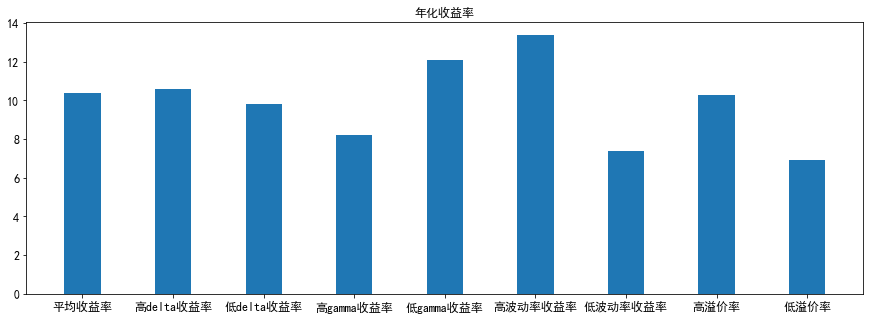

In [12]:
title_list=["平均收益率","高delta收益率","低delta收益率",
            "高gamma收益率","低gamma收益率",
            "高波动率收益率","低波动率收益率","高溢价率","低溢价率"]
plot_type="ar"   # caar
title_y=[index_data[plot_type]
    ,ana_field("delta均值",True,0)[1][plot_type],
        ana_field("delta均值",False,0)[1][plot_type],
        ana_field("gamma均值",True,0)[1][plot_type],
        ana_field("gamma均值",False,0)[1][plot_type],
        ana_field("股票平均波动率",True,0)[1][plot_type],
        ana_field("股票平均波动率",False,0)[1][plot_type],
        ana_field("平均溢价率",True,0)[1][plot_type],
        ana_field("平均溢价率",False,0)[1][plot_type]]

plt.figure(figsize=(15,5))
plt.title("年化收益率")
plt.bar(title_list,title_y,width=0.4)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig("ana_data/{}.png".format("各指标相关收益率统计图"))
plt.show()

<font size=6>下面选取转债(128021)进行分析，探究收益率曲线和各指标值之间的关系</font>

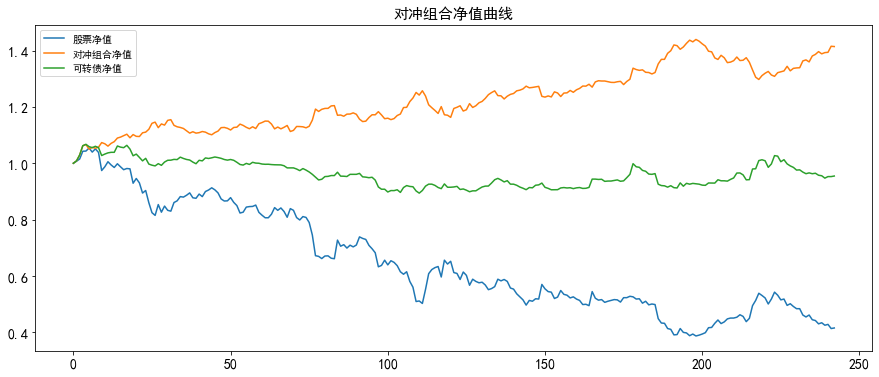

In [13]:
date_data=backtest_data["128021"]["date_data"]
stock_value_list=[v["stock_net_value"] for v in date_data]
bond_value_list=[v["bond_net_value"] for v in date_data]
stock_price_list=[v["stock_price_fq"] for v in date_data]
net_value_list=[v["net_value"] for v in date_data]
delta_value_list=[v["delta"] for v in date_data[1:]]
sigma_value_list=[v["sigma"] for v in date_data[1:]]
gamma_value_list=[v["gamma"] for v in date_data[2:]]
convert_price_list=[v["convert_price"] for v in date_data[1:]]

plt.figure(figsize=(15,6))
plt.title("对冲组合净值曲线",fontsize=15)
plt.plot(stock_value_list,label="股票净值")
plt.plot(net_value_list,label="对冲组合净值")
plt.plot(bond_value_list,label="可转债净值")
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend()
plt.savefig("ana_data/{}.png".format("对冲组合净值曲线"))
plt.show()

<font size=5>观察三者净值曲线，可见策略能够良好的避免市场下跌带来的亏损，和赚取市场波动带来的利润</font>

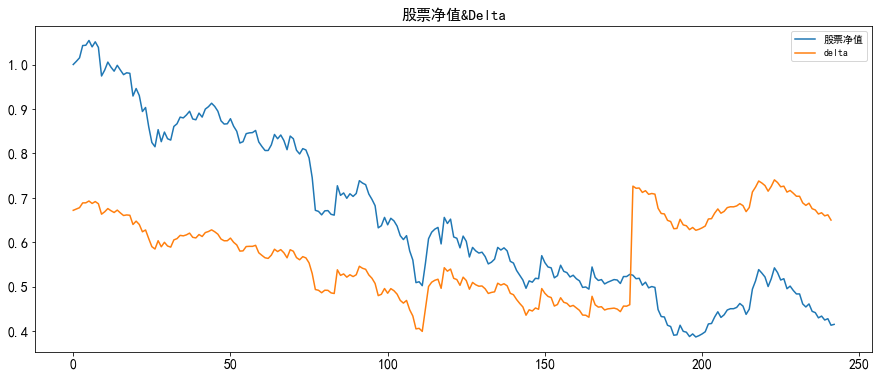

In [14]:
figure=plt.figure(figsize=(15,6))
plt.title("股票净值&Delta",fontsize=15)
plt.plot(stock_value_list,label="股票净值")
plt.plot(delta_value_list,label="delta")
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend()
plt.savefig("ana_data/{}.png".format("股票净值&Delta"))
plt.show()

<font size=5>上图可见delta值位于0到1之间，且股票上涨时delta增大，下跌时delta减小。图中可见delta值有一段明显的突然上升，是由于当天大幅下调转股价所致。</font>

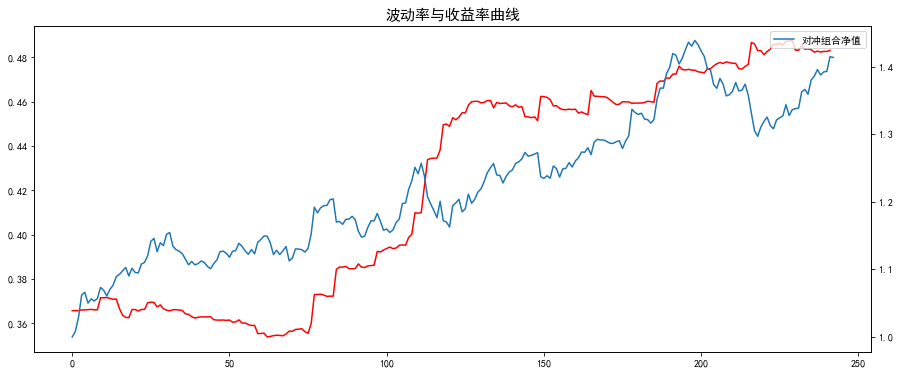

In [15]:
figure=plt.figure(figsize=(15,6))
ax1=figure.add_subplot(111)
ax2=ax1.twinx()
plt.title("波动率与收益率曲线",fontsize=15)
l1=ax1.plot(sigma_value_list,label="波动率",color="r")
l2=ax2.plot(net_value_list,label="对冲组合净值")
plt.legend()
plt.savefig("ana_data/{}.png".format("波动率与收益率曲线"))
plt.show()

<font size=5>上图可见波动率与组合收益率呈现一个总体上升的走势</font>

## 详细交易记录

In [16]:
print("持有1份可转债")
for v in backtest_data["128021"]["trade_data"]:
    print("日期：{}，Delta：{}，{}：{}股".format(v["date"],round(v["delta"],2),
                                         {"sell":"卖出","buy":"买入"}[v["type"]],v["volume"]))

持有1份可转债
日期：2018-01-08，Delta：0.69，卖出：4.2股
日期：2018-01-29，Delta：0.66，卖出：0.1股
日期：2018-03-05，Delta：0.61，买入：0.1股
日期：2018-03-19，Delta：0.6，卖出：0.1股
日期：2018-03-26，Delta：0.58，买入：0.1股
日期：2018-04-23，Delta：0.57，买入：0.1股
日期：2018-05-07，Delta：0.49，卖出：0.1股
日期：2018-05-14，Delta：0.54，卖出：0.1股
日期：2018-06-04，Delta：0.5，买入：0.3股
日期：2018-06-25，Delta：0.5，卖出：0.8股
日期：2018-07-09，Delta：0.5，卖出：0.1股
日期：2018-07-16，Delta：0.5，卖出：0.1股
日期：2018-07-23，Delta：0.49，卖出：0.3股
日期：2018-08-06，Delta：0.45，买入：0.1股
日期：2018-08-20，Delta：0.46，买入：0.1股
日期：2018-09-10，Delta：0.46，卖出：0.4股
日期：2018-09-17，Delta：0.45，买入：0.1股
日期：2018-10-08，Delta：0.72，卖出：5.3股
日期：2018-10-15，Delta：0.66，卖出：0.5股
日期：2018-10-22，Delta：0.63，卖出：0.5股
日期：2018-10-29，Delta：0.63，卖出：0.3股
日期：2018-11-05，Delta：0.65，买入：0.4股
日期：2018-11-12，Delta：0.67，买入：0.2股
日期：2018-11-26，Delta：0.72，买入：0.5股
日期：2018-12-03，Delta：0.73，卖出：0.1股
日期：2018-12-10，Delta：0.71，卖出：0.4股
日期：2018-12-17，Delta：0.69，卖出：0.1股
日期：2018-12-24，Delta：0.66，卖出：0.3股
